# Evolutionary algorithm experiments

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import random

from constants import PATH_PURE_COMPONENTS, PATH_MIXTURES, X
from file_io import load_pickle_file
from nnls_fit_with_x_axis_correction import analyze, nnls_fit_with_interpolated_library
from utils import calculate_signal, nnls_fit, rsme
from correction_models import quadratic_correction

from numpy.random import normal

logging.basicConfig(level=logging.INFO)

## Load data

In [3]:
pure_components = load_pickle_file(PATH_PURE_COMPONENTS)
mixtures_data = load_pickle_file(PATH_MIXTURES)

## Analysis

### Constants

In [4]:
N_POPULATION = 200
N_SURVIVORS = 30
N_LINEAR_COMBINATIONS = 30
N_MUTATIONS = 100
INIT_GUESS = [0, 0, 0]
INIT_DEVIATIONS = [0.01, 0.1, 1]
N_MAX_GENERATIONS = 300
RSME_THRESHOLD = 2
N_STEADY_THRESHOLD = 50
MAX_X_DEVIATION = 50

In [5]:
correction_model = quadratic_correction
x_original = X
signal = mixtures_data[0]['signal']
true = mixtures_data[0]['contributions']

### Optimization

In [6]:
parameters = []
for _ in range(N_POPULATION):
    candidate = [normal(loc=mean, scale=stdev) for mean, stdev in zip(INIT_GUESS, INIT_DEVIATIONS)]
    parameters.append(candidate)
parameters = np.array(parameters) 

min_rsme = float(np.inf)
best_solution = None
all_rsme_values = []
counter = 0

In [7]:
for k in range(1, N_MAX_GENERATIONS):
    counter += 1
    rsme_values = []
    
    for candidate in parameters:
        x_target = correction_model(x_original, candidate)
        
        if abs(min(x_target) - min(x_original)) > MAX_X_DEVIATION:
            rsme_values.append(float(np.inf))
            continue
        if abs(max(x_target) - max(x_original)) > MAX_X_DEVIATION:
            rsme_values.append(float(np.inf))
            continue
            
        solution, residual = nnls_fit_with_interpolated_library(x_original, x_target, pure_components, signal)
        rsme_value = rsme(residual)
        rsme_values.append(rsme_value)
        if rsme_value < min_rsme:
            min_rsme = rsme_value
            best_solution = solution
            counter = 0
            print(k, min_rsme, solution)
    
    all_rsme_values.append(rsme_values)
    
    if min_rsme < RSME_THRESHOLD:
        print(f'Target RSME reached. Iteration terminated at round {k}.')
        break
        
    if counter > N_STEADY_THRESHOLD:
        print(f"RSME didn't change in last {N_STEADY_THRESHOLD} rounds. Iteration terminated at round {k}.")
        break
    
    sorted_indices = np.argsort(rsme_values)
    survivors = parameters[sorted_indices][:N_SURVIVORS]
    best_parameters = survivors[0]

    parameters = []
    parameters.append(best_parameters)

    for _ in range(N_LINEAR_COMBINATIONS):
        candidate = [random.choice(column) for column in survivors.T]
        parameters.append(candidate)

    for _ in range(N_MUTATIONS):
        candidate = [normal(loc=mean, scale=stdev) for mean, stdev in zip(best_parameters, INIT_DEVIATIONS)]
        parameters.append(candidate)

    for _ in range(N_POPULATION - len(parameters)):
        candidate = [normal(loc=mean, scale=stdev) for mean, stdev in zip(INIT_GUESS, INIT_DEVIATIONS)]
        parameters.append(candidate)
    
    parameters = np.array(parameters)

print('True contributions: ', true)

1 898.3911802572093 [54.18181952 85.97987551  0.        ]
1 581.926856776246 [ 34.59144026 278.95068951   0.        ]
1 252.25676645690578 [ 28.14669585 346.97768173   0.        ]
1 83.73780100448437 [ 25.11168285 385.29931371  53.80329762]
1 30.081501508525555 [ 27.79355489 398.46234507   2.50372241]
5 9.655628201387787 [ 25.57545844 389.07986233  19.48269917]
7 5.008113759262555 [ 26.06901166 390.3440083   12.56862681]
26 4.216652639739476 [ 26.03998684 390.26993106  13.20155727]
66 2.763539398357712 [ 25.73192142 389.03000789  16.77395809]
RSME didn't change in last 50 rounds. Iteration terminated at round 117.
True contributions:  [ 25.53884062 389.36144086  14.74869716]


### Results

C:\Users\ossi\Anaconda3\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


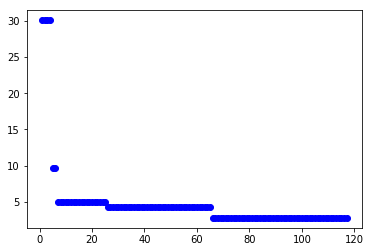

In [8]:
for i, row in enumerate(all_rsme_values,1):
    rsme_min = min(row)
    rsme_stdev = np.std(row)
    rsme_mean = np.mean(row)
    _ = plt.plot(i, rsme_min, 'bo')

## Test refactored version

In [9]:
from nnls_fit_with_x_axis_correction import solve_with_EA

In [10]:
solution, parameters = solve_with_EA(x_original,
                  signal,
                  pure_components,
                  correction_model,
                                    n_max_generations=300)

INFO:nnls_fit_with_x_axis_correction:Solution updated: Round 1, RSME 179.5281179016847
INFO:nnls_fit_with_x_axis_correction:Solution updated: Round 1, RSME 173.19900733398228
INFO:nnls_fit_with_x_axis_correction:Solution updated: Round 1, RSME 150.53750307646578
INFO:nnls_fit_with_x_axis_correction:Solution updated: Round 1, RSME 98.7837728641146
INFO:nnls_fit_with_x_axis_correction:Solution updated: Round 1, RSME 56.55576262136594
INFO:nnls_fit_with_x_axis_correction:Solution updated: Round 1, RSME 37.77254084620927
INFO:nnls_fit_with_x_axis_correction:Solution updated: Round 2, RSME 23.807669317749905
INFO:nnls_fit_with_x_axis_correction:Solution updated: Round 3, RSME 21.715375652096682
INFO:nnls_fit_with_x_axis_correction:Solution updated: Round 5, RSME 13.430299372350017
INFO:nnls_fit_with_x_axis_correction:Solution updated: Round 6, RSME 12.650088210519797
INFO:nnls_fit_with_x_axis_correction:Solution updated: Round 8, RSME 7.885072724238668
INFO:nnls_fit_with_x_axis_correction:S